In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential , Input, layers , losses , optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.efficientnet import EfficientNetB3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
from keras.layers import concatenate
from keras.layers import Input
from keras.optimizers import Adam, Adamax
from keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras import regularizers
from tensorflow.keras.layers import Attention
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Attention, Concatenate, Lambda, Layer
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Curated X-Ray Dataset'
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

In [4]:
test_data_dir0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Curated X-Ray Dataset/test_set'
train_data_dir0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Curated X-Ray Dataset/train_set'
valid_data_dir0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Curated X-Ray Dataset/valid_set'

In [5]:
datagen = ImageDataGenerator(rescale=1.0 / 255)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,      # Rescale pixel values to [0, 1]
    rotation_range=20,      # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2, # Randomly shift images vertically by 20% of the height
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom images by 20%
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # How to fill newly created pixels after rotation or shifts
)

In [10]:
# Set batch size and image size
batch_size = 32
image_size = (224, 224)

train_dataset = train_datagen.flow_from_directory(
    train_data_dir0,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True,
    subset='training'  # Use this if you have separate train and validation folders
)

validation_dataset = datagen.flow_from_directory(
    valid_data_dir0,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False,
)


test_dataset = datagen.flow_from_directory(
    test_data_dir0,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False  # Keep the original order of test images
)


Found 6444 images belonging to 4 classes.
Found 1381 images belonging to 4 classes.
Found 1382 images belonging to 4 classes.


In [11]:
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
num_clases = 4

In [12]:
model = VGG16(weights='imagenet', include_top=False)
# Freezing the top to intermediate layers means we are keeping the pre-trained weights and we are not training it from scratch.
for layer in model.layers:
       layer.trainable = False
model_vgg = model(input_layer)
model_vgg = GlobalAveragePooling2D()(model_vgg)
output_vgg = Flatten()(model_vgg)
#first model
mobilenet_base = MobileNetV2(weights = 'imagenet',input_shape = input_shape,include_top = False)

densenet_base = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)
for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False

model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)
model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

inception_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze the base model layers for fine-tuning
for layer in inception_base.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
model_inception = inception_base(input_layer)
model_inception = GlobalAveragePooling2D()(model_inception)
output_inception = Flatten()(model_inception)
# predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model for fine-tuning
# model_inception = Model(inputs=inception_base.input, outputs=predictions)



219055592/219055592 [==============================] - 2s 0us/step


In [15]:
# Merge the attention outputs
merged = concatenate([output_vgg, output_inception, output_mobilenet, output_densenet], name='concatenated')

# merged = concatenate([output_vgg, output_mobilenet, output_densenet], name = 'concatenated')

final_layer =  Dense(4, activation = "softmax", name = "output_layer")(merged)
stacked_model = Model(inputs = input_layer, outputs = final_layer)

In [ ]:
final_layer =  Dense(4, activation = "softmax", name = "output_layer")(output_inception)
stacked_model = Model(inputs = input_layer, outputs = final_layer)

In [16]:

tf.keras.layers.Concatenate()
# stacked_model it is the final model ready for the predictions.
# Model Building
                                                                                                              #  The output of the stacked model
# Model Compilation
# So far we have designed our model, its time to assign some learning parameters and compile the model.

# LR = 0.0001
# optimizer = adam
# We are trying adam optimizer and LR = 0.0001, the small rate of learning is the better starting for the pre-trained model.

optm = Adam(learning_rate=0.0001)
stacked_model.compile(loss='categorical_crossentropy', optimizer=optm,
                  metrics=['accuracy'])
# Step 6 Defining Callbacks
# Callbacks are a tool for efficient training, but it’s not mandatory to use, and it gives us control over the training.

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)
# EarlyStopping: It stops the training if the model doesn’t get better results after some epochs.

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)
# ReduceLROnPlateau It reduces the rate of learning (LR) if the model doesn’t get better.

model_save = tf.keras.callbacks.ModelCheckpoint('./stacked_model_4.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)
# ModelCheckpoint : it saves the model at several epochs.

# Step 7 Training
# Now we are ready with the model and data, it’s time to start the training

# nb_train_samples = 6444 # number of training-samples
# nb_validation_samples = 1381 # number of validation-samples
# nb_test_samples = 1382 # number of training-samples
# epochs = 20
# batch_size  = 16
# Training



In [17]:
stacked_history = stacked_model.fit(train_dataset,
                              # steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_dataset,
                              # class_weight=class_weights,
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
202/202 [==============================] - ETA: 0s - loss: 0.8606 - accuracy: 0.6634 
Epoch 1: val_loss improved from inf to 0.72828, saving model to ./stacked_model_4.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - 3332s 16s/step - loss: 0.8606 - accuracy: 0.6634 - val_loss: 0.7283 - val_accuracy: 0.6896 - lr: 1.0000e-04
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7714
Epoch 2: val_loss improved from 0.72828 to 0.60252, saving model to ./stacked_model_4.h5
202/202 [==============================] - 241s 1s/step - loss: 0.5777 - accuracy: 0.7714 - val_loss: 0.6025 - val_accuracy: 0.7323 - lr: 1.0000e-04
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7872
Epoch 3: val_loss improved from 0.60252 to 0.54072, saving model to ./stacked_model_4.h5
202/202 [==============================] - 239s 1s/step - loss: 0.5275 - accuracy: 0.7872 - val_loss: 0.5407 - val_accuracy: 0.7677 - lr: 1.0000e-04
Epoch 4/20
202/202 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8071
Epoch 4: val_loss did not improve from 0.54072
202/202 [=============================

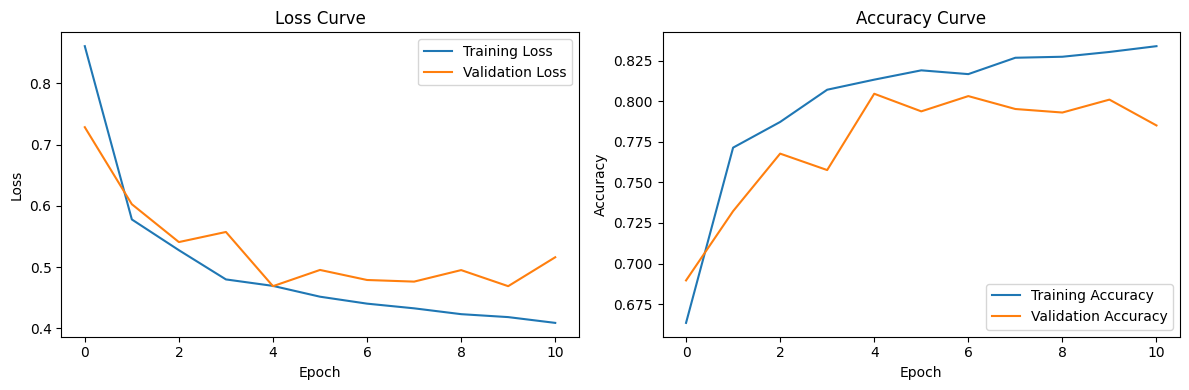

In [19]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(stacked_history.history['loss'], label='Training Loss')
plt.plot(stacked_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(stacked_history.history['accuracy'], label='Training Accuracy')
plt.plot(stacked_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.tight_layout()
plt.show()